# Adversarial Patch Attack

In [1]:
## standard libraries
import os
import json
import math
import time
import numpy as np
import scipy.linalg

## plotting libraries
import matplotlib.pyplot as plt

%matplotlib inline
from IPython.display import set_matplotlib_formats

set_matplotlib_formats("svg", "pdf")  # For export
from matplotlib.colors import to_rgb
import matplotlib

matplotlib.rcParams["lines.linewidth"] = 2.0
import seaborn as sns

sns.set()

## image processing libraries
from tqdm.notebook import tqdm

## pytorch libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim

# Torchvision
import torchvision
from torchvision.datasets import CIFAR10
from torchvision import transforms

# PyTorch Lightning
try:
    import pytorch_lightning as pl
except ModuleNotFoundError:  # Google Colab does not have PyTorch Lightning installed by default. Hence, we do it here if necessary
    !pip install --quiet pytorch-lightning>=1.4
    import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint

# Path to the folder where the datasets are/should be downloaded (e.g. MNIST)
DATASET_PATH = "../data"
# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = "../saved_models"

# Setting the seed
pl.seed_everything(42)

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Fetching the device that will be used throughout this notebook
device = (
    torch.device("cpu") if not torch.cuda.is_available() else torch.device("cuda:0")
)
print("Using device", device)

# from tools
# Move up one directory to import from the tools folder
%cd ..
from tools.resnet20 import ResNetCIFAR
from tools.train_util import *

# Move back to the adversarial patch folder
!pwd
%cd /workspaces/Adversarial_Patch_Attack/adversarial patch

/tmp/ipykernel_17958/2487907964.py:15: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats("svg", "pdf")  # For export
Global seed set to 42


Using device cuda:0
/workspaces/Adversarial_Patch_Attack
/workspaces/Adversarial_Patch_Attack
/workspaces/Adversarial_Patch_Attack/adversarial patch


In [2]:
# create the directories if they do not exist
os.makedirs(DATASET_PATH, exist_ok=True)
os.makedirs(CHECKPOINT_PATH, exist_ok=True)

## ResNet20 on CIFAR-10

In [3]:
# load ResNet20 architecture pretrained on CIFAR-10
os.environ["TORCH_HOME"] = CHECKPOINT_PATH
pretrained_model = ResNetCIFAR(num_layers=20, Nbits=None)
pretrained_model = pretrained_model.to(device)
pretrained_model.load_state_dict(
    torch.load(
        "/workspaces/Adversarial_Patch_Attack/tools/pretrained_model_resnet20.pt",
        map_location=torch.device("cpu"),
    )
)

# set the model to evaluation mode
pretrained_model.eval()
for p in pretrained_model.parameters():
    p.requires_grad = False

Perform attacks on CIFAR-10 images. Load images and create data loader.

In [4]:
# Load CIFAR10 dataset
NORM_MEAN = np.array([0.4914, 0.4822, 0.4465])
NORM_STD = np.array([0.2023, 0.1994, 0.2010])
# No resizing and center crop necessary 
plain_transforms = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize(mean=NORM_MEAN, std=NORM_STD),
    ]
)
test_transforms = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize(mean=NORM_MEAN, std=NORM_STD),
    ]
)
# load CIFAR10 training set
dataset = torchvision.datasets.CIFAR10(
    root=DATASET_PATH, train=True, download=True, transform=plain_transforms
)
data_loader = data.DataLoader(
    dataset, batch_size=128, shuffle=False, drop_last=False, num_workers=8
)
# load CIFAR10 test set
test_dataset = torchvision.datasets.CIFAR10(
    root=DATASET_PATH, train=False, download=True, transform=test_transforms
)
test_data_loader = data.DataLoader(
    test_dataset, batch_size=128, shuffle=False, drop_last=False, num_workers=8
)

# get label names of CIFAR10 class
label_names = dataset.classes
print(label_names)

# get label index of CIFAR10 class
def get_label_index(lab_str):
    assert (
        lab_str in label_names
    ), f'Label "{lab_str}" not found. Please use one of the following labels: {label_names}'
    return label_names.index(lab_str)

# try get_label_index
get_label_index("cat")

Files already downloaded and verified


/home/codespace/venv/lib/python3.8/site-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 6, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Files already downloaded and verified
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


3

In [6]:
# get size of dataset and test set
dataset_size = len(dataset)
test_dataset_size = len(test_dataset)
print(f"Dataset size: {dataset_size}")
print(f"Test dataset size: {test_dataset_size}")

Dataset size: 50000
Test dataset size: 10000


Verify model performance using the error (1 - accuracy) instead of the accuracy.

In [7]:
# evaluate the model on the test set
def eval_model(dataset_loader, img_func=None):
    tp, counter = 0.0, 0.0
    for imgs, labels in tqdm(dataset_loader, desc="Validating..."):
        imgs = imgs.to(device)
        labels = labels.to(device)
        if img_func is not None:
            imgs = img_func(imgs, labels)
        with torch.no_grad():
            preds = pretrained_model(imgs)
        tp += (preds.argmax(dim=-1) == labels).sum()
        counter += preds.shape[0]
    acc = tp.float().item() / counter
    print(f"Error: {(100.0 * (1 - acc)):4.2f}%")
    return acc

In [8]:
_ = eval_model(test_data_loader)

Validating...:   0%|          | 0/79 [00:00<?, ?it/s]

Error: 8.49%


Function show_prediction plots an image along with a bar diagram of its top 2 predictions. We also prepare it to show adversarial examples for later applications.

In [11]:
# get the prediction of the model
def show_prediction(img, label, pred, K=2, adv_img=None, noise=None):

    if isinstance(img, torch.Tensor):
        # Tensor image to numpy
        img = img.cpu().permute(1, 2, 0).numpy()
        img = (img * NORM_STD[None, None]) + NORM_MEAN[None, None]
        img = np.clip(img, a_min=0.0, a_max=1.0)
        label = label.item()

    # Plot on the left the image with the true label as title.
    # On the right, have a horizontal bar plot with the top k predictions including probabilities
    if noise is None or adv_img is None:
        fig, ax = plt.subplots(
            1, 2, figsize=(10, 2), gridspec_kw={"width_ratios": [1, 1]}
        )
    else:
        fig, ax = plt.subplots(
            1, 5, figsize=(12, 2), gridspec_kw={"width_ratios": [1, 1, 1, 1, 2]}
        )

    ax[0].imshow(img)
    ax[0].set_title(label_names[label])
    ax[0].axis("off")

    if adv_img is not None and noise is not None:
        # Visualize adversarial images
        adv_img = adv_img.cpu().permute(1, 2, 0).numpy()
        adv_img = (adv_img * NORM_STD[None, None]) + NORM_MEAN[None, None]
        adv_img = np.clip(adv_img, a_min=0.0, a_max=1.0)
        ax[1].imshow(adv_img)
        ax[1].set_title("Adversarial")
        ax[1].axis("off")
        # Visualize noise
        noise = noise.cpu().permute(1, 2, 0).numpy()
        noise = noise * 0.5 + 0.5  # Scale between 0 to 1
        ax[2].imshow(noise)
        ax[2].set_title("Noise")
        ax[2].axis("off")
        # buffer
        ax[3].axis("off")

    if abs(pred.sum().item() - 1.0) > 1e-4:
        pred = torch.softmax(pred, dim=-1)
    topk_vals, topk_idx = pred.topk(K, dim=-1)
    print(topk_idx)
    topk_vals, topk_idx = topk_vals.cpu().numpy(), topk_idx.cpu().numpy()
    ax[-1].barh(
        np.arange(K),
        topk_vals * 100.0,
        align="center",
        color=["C0" if topk_idx[i] != label else "C2" for i in range(K)],
    )
    ax[-1].set_yticks(np.arange(K))
    ax[-1].set_yticklabels([label_names[c] for c in topk_idx])
    ax[-1].invert_yaxis()
    ax[-1].set_xlabel("Confidence")
    ax[-1].set_title("Predictions")

    plt.show()
    plt.close()

tensor([8, 1], device='cuda:0')


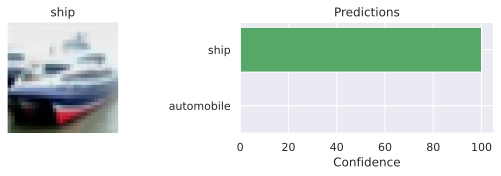

tensor([1, 9], device='cuda:0')


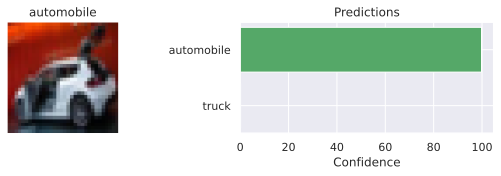

tensor([9, 1], device='cuda:0')


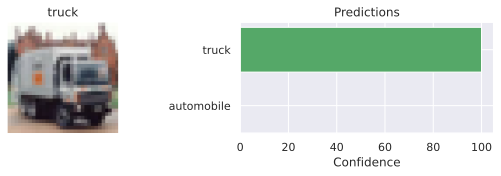

tensor([5, 7], device='cuda:0')


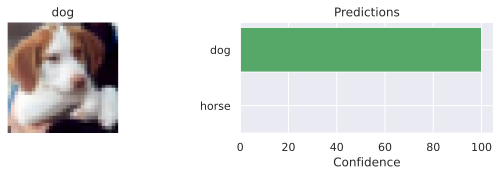

In [12]:
# visualize some predictions of the model
exmp_batch, label_batch = next(iter(test_data_loader))
with torch.no_grad():
    preds = pretrained_model(exmp_batch.to(device))

for i in range(1, 17, 5):
    show_prediction(exmp_batch[i], label_batch[i], preds[i])

### Adversarial Patches

Create an image patch to cover an area of the original image for a targetted patch attack. This image patch will cause the model to predict a specific classs using [Tom Brown et al.](https://arxiv.org/pdf/1712.09665.pdf) to learn this adversarial image patch and cause the network prediction to change. 

To train patch: 
1. Calculate input gradient by replacing part of input image with patch and calculate just the patch gradient
2. Train patch with SGD so that pretrained model predicts a specific class 


Unlike [Brown et al.](https://arxiv.org/pdf/1712.09665.pdf), we did not randomly rotate or scale the patch during training before palcing it at a random place in the input image. We wonly randomly placed a patch on the image. 

Patch is an `nn.Parameter` with values in range $-\infty$ and $\infty$, but images are limited to range of CIFAR-10, so patch_forward function limits the range.

In [9]:
TENSOR_MEANS, TENSOR_STD = (
    torch.FloatTensor(NORM_MEAN)[:, None, None],
    torch.FloatTensor(NORM_STD)[:, None, None],
)


def patch_forward(patch):
    # map patch values from [-infty,infty] to ImageNet min and max
    patch = (torch.tanh(patch) + 1 - 2 * TENSOR_MEANS) / (2 * TENSOR_STD)
    return patch

In [10]:
# randomly place a patch on the image
def place_patch(img, patch):
    for i in range(img.shape[0]):
        h_offset = np.random.randint(0, img.shape[2] - patch.shape[1] - 1)
        w_offset = np.random.randint(0, img.shape[3] - patch.shape[2] - 1)
        img[
            i,
            :,
            h_offset : h_offset + patch.shape[1],
            w_offset : w_offset + patch.shape[2],
        ] = patch_forward(patch)
    return img

Create eval_patch to evaluate success of a patch by how many time it can fool the network into predicting target class.

In [11]:
# evaluate the patch on the validation set
def eval_patch(model, patch, val_loader, target_class):
    model.eval()
    tp, counter = 0.0, 0.0
    with torch.no_grad():
        for img, img_labels in tqdm(val_loader, desc="Validating...", leave=False):
            # place the patch at 4 random locations per image, and average the performance
            for _ in range(4):
                patch_img = place_patch(img, patch)
                patch_img = patch_img.to(device)
                img_labels = img_labels.to(device)
                pred = model(patch_img)
                # exclude the images that are of our target class since we would not "fool" the model into
                # predicting those
                tp += torch.logical_and(
                    pred.argmax(dim=-1) == target_class, img_labels != target_class
                ).sum()
                counter += (img_labels != target_class).sum()
    acc = tp / counter
    return acc

In [12]:
# eval_patch for untargeted attack
def eval_patch_untargeted(model, patch, val_loader):
    model.eval()
    tp, counter = 0.0, 0.0
    with torch.no_grad():
        for img, img_labels in tqdm(val_loader, desc="Validating...", leave=False):
            # For stability, place the patch at 4 random locations per image, and average the performance
            for _ in range(4):
                patch_img = place_patch(img, patch)
                patch_img = patch_img.to(device)
                img_labels = img_labels.to(device)
                pred = model(patch_img)
                # In the accuracy calculation, we need to exclude the images that are of our target class
                # as we would not "fool" the model into predicting those
                tp += torch.logical_and(
                    pred.argmax(dim=-1) != img_labels
                ).sum()
                counter += (img_labels).sum()
    acc = tp / counter
    return acc

Create targeted patch_attack function which trains the patch_attack provided a model, class for patch to predict, and patch size (number of pixels) using SGD optimizer with momentum to minimize the classification loss of the model given the patch in the image. Patch will look more like class over the iterations.

In [13]:
# targeted patch attack
def patch_attack(model, target_class, patch_size=16, num_epochs=5):
    # create dataset and dataloader for train and validation
    train_set = dataset
    val_set = test_dataset
    train_loader = data.DataLoader(
        train_set, batch_size=128, shuffle=True, drop_last=True, num_workers=8
    )
    val_loader = data.DataLoader(
        val_set, batch_size=128, shuffle=False, drop_last=False, num_workers=4
    )

    # create patch and optimizer
    if not isinstance(patch_size, tuple):
        patch_size = (patch_size, patch_size)
    patch = nn.Parameter(
        torch.zeros(3, patch_size[0], patch_size[1]), requires_grad=True
    )
    optimizer = torch.optim.SGD([patch], lr=1e-1, momentum=0.8)
    loss_module = nn.CrossEntropyLoss()

    # train the patch
    for epoch in range(num_epochs):
        t = tqdm(train_loader, leave=False)
        for img, _ in t:
            img = place_patch(img, patch)
            img = img.to(device)
            pred = model(img)
            labels = torch.zeros(
                img.shape[0], device=pred.device, dtype=torch.long
            ).fill_(target_class)
            loss = loss_module(pred, labels)
            optimizer.zero_grad()
            loss.mean().backward()
            optimizer.step()
            t.set_description(f"Epoch {epoch}, Loss: {loss.item():4.2f}")

    # evaluate the patch
    acc = eval_patch(model, patch, val_loader, target_class)

    return patch.data, {"acc": acc.item()}

In [14]:
# function for untargeted patch attack, don't have to specify target class
def patch_attack_untargeted(model, patch_size=16, num_epochs=5):
    train_set = dataset
    val_set = test_dataset
    train_loader = data.DataLoader(
        train_set, batch_size=128, shuffle=True, drop_last=True, num_workers=8
    )
    val_loader = data.DataLoader(
        val_set, batch_size=128, shuffle=False, drop_last=False, num_workers=4
    )
    # create patch and optimizer
    if not isinstance(patch_size, tuple):
        patch_size = (patch_size, patch_size)
    patch = nn.Parameter(
        torch.zeros(3, patch_size[0], patch_size[1]), requires_grad=True
    )
    optimizer = torch.optim.SGD([patch], lr=1e-1, momentum=0.8)
    loss_module = nn.CrossEntropyLoss()
    
    # train the patch
    for epoch in range(num_epochs):
        t = tqdm(train_loader, leave=False)
        for img, img_labels in t:
            img = place_patch(img, patch)
            img = img.to(device)
            pred = model(img)
            labels = img_labels.to(device)
            loss = loss_module(pred, labels)
            optimizer.zero_grad()
            loss.mean().backward()
            optimizer.step()
            t.set_description(f"Epoch {epoch}, Loss: {loss.item():4.2f}")

    # evaluate the patch
    acc = eval_patch(model, patch, val_loader)

Save pre-trained patches and results in JSON file. 

In [15]:
# save the patch for later use
json_results_file = os.path.join(CHECKPOINT_PATH, "patch_results.json")
json_results = {}
if os.path.isfile(json_results_file):
    with open(json_results_file, "r") as f:
        json_results = json.load(f)

def save_results(patch_dict):
    result_dict = {
        cname: {
            psize: [
                t.item() if isinstance(t, torch.Tensor) else t
                for t in patch_dict[cname][psize]["results"]
            ]
            for psize in patch_dict[cname]
        }
        for cname in patch_dict
    }
    with open(os.path.join(CHECKPOINT_PATH, "patch_results.json"), "w") as f:
        json.dump(result_dict, f, indent=4)

Create get_patches function to train and evaluate patches for all 10 classes in CIFAR10 on patch sizes $3\times3$ pixels, $5\times5$ pixels, $7\times7$ pixels, and $16\times16$ pixels.

In [17]:
os.path.join(CHECKPOINT_PATH, f"{'ship'}_{3}_patch.pt")

'../saved_models/ship_3_patch.pt'

In [18]:
def get_patches(class_names, patch_sizes):
    result_dict = dict()
    # load pretrained model for the target class
    for name in class_names:
        result_dict[name] = dict()
        for patch_size in patch_sizes:
            c = label_names.index(name)
            file_name = os.path.join(CHECKPOINT_PATH, f"{name}_{patch_size}_patch.pt")
            # load patch if exist, otherwise train the patch
            if not os.path.isfile(file_name):
                patch, val_results = patch_attack(
                    pretrained_model,
                    target_class=c,
                    patch_size=patch_size,
                    num_epochs=5,
                )
                print(f"Validation results for {name} and {patch_size}:", val_results)
                torch.save(patch, file_name)
            else:
                patch = torch.load(file_name)
            # evaluate the patch if not evaluated before
            if name in json_results:
                results = json_results[name][str(patch_size)]
            else:

                results = eval_patch(
                    pretrained_model, patch, test_data_loader, target_class=c
                )

            # save the results
            result_dict[name][patch_size] = {"results": results, "patch": patch}

    return result_dict

In [19]:
class_names = label_names
patch_sizes = [3, 5, 7, 16]

patch_dict = get_patches(class_names, patch_sizes)

Validating...:   0%|          | 0/79 [00:00<?, ?it/s]

Validating...:   0%|          | 0/79 [00:00<?, ?it/s]

Validating...:   0%|          | 0/79 [00:00<?, ?it/s]

Validating...:   0%|          | 0/79 [00:00<?, ?it/s]

Validating...:   0%|          | 0/79 [00:00<?, ?it/s]

Validating...:   0%|          | 0/79 [00:00<?, ?it/s]

Validating...:   0%|          | 0/79 [00:00<?, ?it/s]

Validating...:   0%|          | 0/79 [00:00<?, ?it/s]

Validating...:   0%|          | 0/79 [00:00<?, ?it/s]

Validating...:   0%|          | 0/79 [00:00<?, ?it/s]

Validating...:   0%|          | 0/79 [00:00<?, ?it/s]

Validating...:   0%|          | 0/79 [00:00<?, ?it/s]

Validating...:   0%|          | 0/79 [00:00<?, ?it/s]

Validating...:   0%|          | 0/79 [00:00<?, ?it/s]

Validating...:   0%|          | 0/79 [00:00<?, ?it/s]

Validating...:   0%|          | 0/79 [00:00<?, ?it/s]

Validating...:   0%|          | 0/79 [00:00<?, ?it/s]

Validating...:   0%|          | 0/79 [00:00<?, ?it/s]

Validating...:   0%|          | 0/79 [00:00<?, ?it/s]

Validating...:   0%|          | 0/79 [00:00<?, ?it/s]

Validating...:   0%|          | 0/79 [00:00<?, ?it/s]

Validating...:   0%|          | 0/79 [00:00<?, ?it/s]

Validating...:   0%|          | 0/79 [00:00<?, ?it/s]

Validating...:   0%|          | 0/79 [00:00<?, ?it/s]

Validating...:   0%|          | 0/79 [00:00<?, ?it/s]

Validating...:   0%|          | 0/79 [00:00<?, ?it/s]

Validating...:   0%|          | 0/79 [00:00<?, ?it/s]

Validating...:   0%|          | 0/79 [00:00<?, ?it/s]

Validating...:   0%|          | 0/79 [00:00<?, ?it/s]

Validating...:   0%|          | 0/79 [00:00<?, ?it/s]

Validating...:   0%|          | 0/79 [00:00<?, ?it/s]

Validating...:   0%|          | 0/79 [00:00<?, ?it/s]

Validating...:   0%|          | 0/79 [00:00<?, ?it/s]

Validating...:   0%|          | 0/79 [00:00<?, ?it/s]

Validating...:   0%|          | 0/79 [00:00<?, ?it/s]

Validating...:   0%|          | 0/79 [00:00<?, ?it/s]

Validating...:   0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/390 [00:00<?, ?it/s]

Validating...:   0%|          | 0/79 [00:00<?, ?it/s]

Validation results for truck and 5: {'acc': 0.16777777671813965}


Validating...:   0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/390 [00:00<?, ?it/s]

Validating...:   0%|          | 0/79 [00:00<?, ?it/s]

Validation results for truck and 7: {'acc': 0.5938888788223267}


Validating...:   0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/390 [00:00<?, ?it/s]

Validating...:   0%|          | 0/79 [00:00<?, ?it/s]

Validation results for truck and 16: {'acc': 0.9995277523994446}


Validating...:   0%|          | 0/79 [00:00<?, ?it/s]

TypeError: iteration over a 0-d tensor

In [ ]:
# save the results
def save_results(patch_dict):
    result_dict = {
        cname: {
            psize: [
                t.item() if isinstance(t, torch.Tensor) else t
                for t in patch_dict[cname][psize]["results"]
            ]
            for psize in patch_dict[cname]
        }
        for cname in patch_dict
    }
    with open(os.path.join(CHECKPOINT_PATH, "patch_results.json"), "w") as f:
        json.dump(result_dict, f, indent=4)
save_results(patch_dict)

## Qualitative results

Create show_patches function to visualize results.

In [25]:
def show_patches():
    fig, ax = plt.subplots(
        len(patch_sizes),
        len(class_names),
        figsize=(len(class_names) * 2.2, len(patch_sizes) * 2.2),
    )
    for c_idx, cname in enumerate(class_names):
        for p_idx, psize in enumerate(patch_sizes):
            patch = patch_dict[cname][psize]["patch"]
            patch = (torch.tanh(patch) + 1) / 2  # Parameter to pixel values
            patch = patch.cpu().permute(1, 2, 0).numpy()
            patch = np.clip(patch, a_min=0.0, a_max=1.0)
            ax[p_idx][c_idx].imshow(patch)
            ax[p_idx][c_idx].set_title(f"{cname}, size {psize}")
            ax[p_idx][c_idx].axis("off")
    fig.subplots_adjust(hspace=0.3, wspace=0.3)
    plt.show()


show_patches()

NameError: name 'patch_dict' is not defined

Error in callback <function flush_figures at 0x7f0085f07040> (for post_execute):


KeyboardInterrupt: 

Results above show patches with different classes and sizes. $16\times 16$ pixels is the smallest size, and it more closesly resembles their classes (e.g. horse) vs. larger patch sizes like $3\times 3$ in terms of color and image. For larger sizes (3x3 to 7x7), you cannot tell that they represent the class. 

## Quantitative results

In [ ]:
%%html
<!-- Some HTML code to increase font size in the following table -->
<style>
th {font-size: 120%;}
td {font-size: 120%;}
</style>

In [ ]:
import tabulate
from IPython.display import display, HTML


def show_table(top_1=True):
    i = 0 if top_1 else 1
    table = [
        [name]
        + [
            f'{(100.0 * patch_dict[name][psize]["results"][i]):4.2f}%'
            for psize in patch_sizes
        ]
        for name in class_names
    ]
    display(
        HTML(
            tabulate.tabulate(
                table,
                tablefmt="html",
                headers=["Class name"]
                + [f"Patch size {psize}x{psize}" for psize in patch_sizes],
            )
        )
    )

First, we will create a table of top-1 accuracy, meaning that how many images have been classified with the target class as highest prediction?

In [ ]:
show_table(top_1=True)

As patch size increases, the targeted patch attack performs better in terms of fooling the model, which accuracy of 99% to 100% for the largest patch size of $16\times 16$. The smallest patch $3\times 3$ has a very poor fooling accuracy. Horse, ship, and deer classes were more difficult to create a patch for patches $5\times 5$ and $7\times 7$. Some classes were more easily predicted than other classes. With just patch size $7\times 7$, the targetted attack patch performs >40% for fooling the model. 

In [ ]:
exmp_batch, label_batch = next(iter(test_data_loader))


def perform_patch_attack(patch):
    patch_batch = exmp_batch.clone()
    patch_batch = place_patch(patch_batch, patch)
    with torch.no_grad():
        patch_preds = pretrained_model(patch_batch.to(device))
    for i in range(1, 17, 5):
        show_prediction(patch_batch[i], label_batch[i], patch_preds[i])

In [ ]:
perform_patch_attack(patch_dict["bird"][3]["patch"])

The tiny goldfish patch can change all of the predictions to "goldfish" as top class. Note that the patch attacks work especially well if the input image is semantically similar to the target class (e.g. a fish and the target class "goldfish" works better than an airplane image with that patch). Nevertheless, we can also let the network predict semantically dis-similar classes by using a larger patch:

In [ ]:
perform_patch_attack(patch_dict["ship"][16]["patch"])

Although none of the images have anything to do with an American school bus, the high confidence of often 100% shows how powerful such attacks can be. With a few lines of code and access to the model, we were able to generate patches that we add to any image to make the model predict any class we want. 

### Transferability of white-box attacks

Evaluate some of our patches trained above on VGG and Densenet networks.

In [ ]:
# densenet121 with pretrained CIFAR10 weights
# import vgg from PyTorch_CIFAR10 folder in another directory and load the pretrained model
import sys

sys.path.append("../PyTorch_CIFAR10")
from cifar10_models.vgg import vgg11_bn, vgg13_bn, vgg16_bn, vgg19_bn
from cifar10_models.densenet import densenet121

In [ ]:
# Pretrained model
transfer_model = vgg11_bn(pretrained=True)
transfer_model = transfer_model.to(device)

# No gradients needed for the network
transfer_model.eval()
for p in transfer_model.parameters():
    p.requires_grad = False

In [ ]:
class_name = "cat"
patch_size = 16
print(f'Testing patch "{class_name}" of size {patch_size}x{patch_size}')

results = eval_patch(
    transfer_model,
    patch_dict[class_name][patch_size]["patch"],
    test_data_loader,
    target_class=label_names.index(class_name),
)

print(f"Top-1 fool accuracy: {(results * 100.0):4.2f}%")

In [ ]:
# Try densenet model with pretrained CIFAR10 weights
# Pretrained model
densenet_model = densenet121(pretrained=True)
densenet_model = densenet_model.to(device)

# No gradients needed for the network
densenet_model.eval()
for p in densenet_model.parameters():
    p.requires_grad = False

In [ ]:
class_name = "cat"
patch_size = 16
print(f'Testing patch "{class_name}" of size {patch_size}x{patch_size}')

results = eval_patch(
    densenet_model,
    patch_dict[class_name][patch_size]["patch"],
    test_data_loader,
    target_class=label_names.index(class_name),
)

print(f"Top-1 fool accuracy: {(results * 100.0):4.2f}%")

Although the fool accuracy is significantly lower than on the original ResNet20, it still has a considerable impact on DenseNet although the networks have completely different architectures and weights. Patch generalizes well because the models have all been trained on the same CIFAR10 data. 

## References

[1] Goodfellow, Ian J., Jonathon Shlens, and Christian Szegedy. "Explaining and harnessing adversarial examples." ICLR 2015.

[2] Hendrik Metzen, Jan, et al. "Universal adversarial perturbations against semantic image segmentation." Proceedings of the IEEE International Conference on Computer Vision. 2017.

[3] Anant Jain. "Breaking neural networks with adversarial attacks." [Blog post](https://towardsdatascience.com/breaking-neural-networks-with-adversarial-attacks-f4290a9a45aa) 2019.